In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [25]:
nPerClass = 1000
imgSize = 91
x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

# initialize tensors containing images and labels
images = torch.zeros(nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(nPerClass, 3)

for i in range(nPerClass):

    # create the gaussian with random centers
    loc = 2*np.random.randn(2) # random offset
    wid = np.abs(np.random.randn()*10 + 5)
    G = np.exp(-((X - loc[0])**2 + (Y - loc[1])**2)/wid)

    # add some noise
    G = G + np.random.randn(imgSize, imgSize)/10


    # add to the tensor
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i,:] = torch.Tensor([loc[0], loc[1], wid])





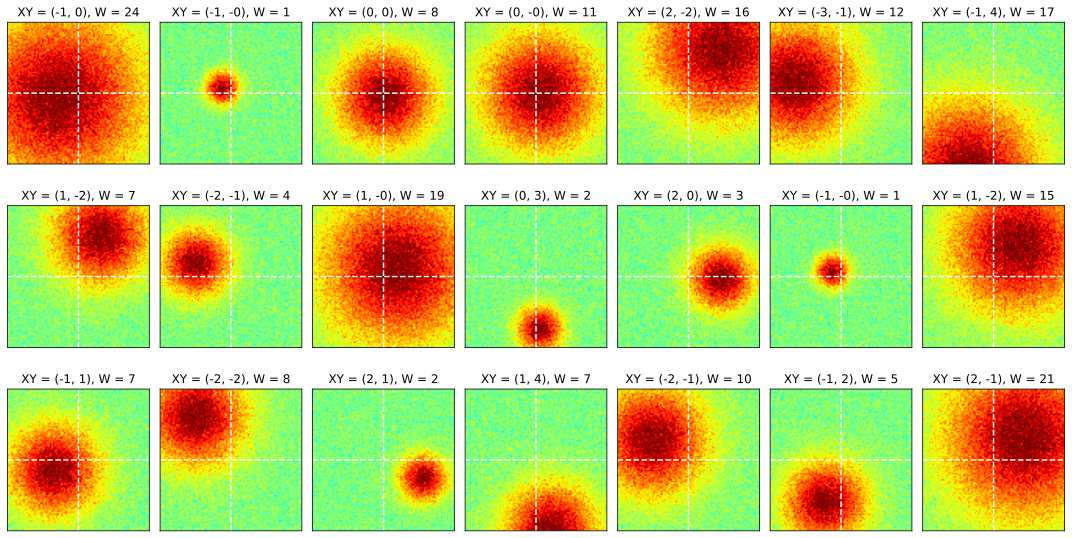

In [27]:
fig, axs = plt.subplots(3, 7, figsize = (15, 8))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nPerClass)
    G = np.squeeze(images[whichpic, :,:, :])
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet', extent = [-4, 4, -4, 4], origin = 'upper')
    ax.set_title(f'XY = ({labels[whichpic, 0]:.0f}, {labels[whichpic,1]:.0f}), W = {labels[whichpic, 2]:.0f}')
    ax.plot([-4, 4],[0,0], 'w--')
    ax.plot([0,0], [-4,4], 'w--')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [28]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size = 0.1)

# convert into pytorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

# converting it into dataloader
train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = len(test_data))

In [29]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([900, 1, 91, 91])
torch.Size([900, 3])


In [30]:
def makeTheNet():

    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding = 1),
                nn.ReLU(),
                nn.AvgPool2d(2,2),
                nn.Conv2d(6, 4, 3, padding = 1),
                nn.ReLU(),
                nn.AvgPool2d(2, 2),
                nn.Flatten(),
                nn.Linear(22*22*4, 50),
                nn.Linear(50, 3)
            )

        def forward(self, x):
            return self.enc(x)

    net = gausnet()

    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer

In [31]:
summary(makeTheNet()[0],(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         AvgPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         AvgPool2d-6            [-1, 4, 22, 22]               0
           Flatten-7                 [-1, 1936]               0
            Linear-8                   [-1, 50]          96,850
            Linear-9                    [-1, 3]             153
Total params: 97,283
Trainable params: 97,283
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.00
Params size (MB): 0.37
Estimated Total Size (MB): 1.41
---------------------------------------------

In [38]:
def function2TrainTheModel():

    numepochs = 500

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # initialize losses
    trainLoss = torch.zeros(numepochs)
    testLoss = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):

        net.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
        trainLoss[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader))
        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
        testLoss[epochi] = loss

    return trainLoss, testLoss, net





In [39]:
trainLoss, testLoss, net = function2TrainTheModel()

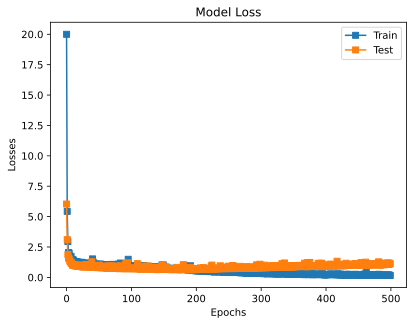

In [40]:

plt.plot(trainLoss, 's-', label = 'Train')
plt.plot(testLoss, 's-', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.title('Model Loss')
plt.legend()
plt.show()

<ipython-input-46-8243bdb47b3b>:20: RuntimeWarning: invalid value encountered in sqrt
  x = cx + np.cos(th)*np.sqrt(rd)
<ipython-input-46-8243bdb47b3b>:21: RuntimeWarning: invalid value encountered in sqrt
  y = cy + np.sin(th)*np.sqrt(rd)


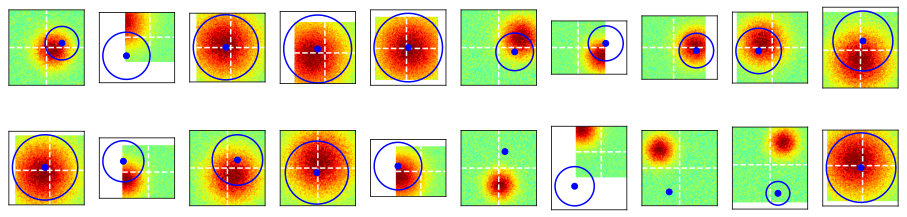

In [46]:
X, y = next(iter(test_loader))

yHat = net(X)

fig, axs = plt.subplots(2, 10, figsize = (16, 4))
th = np.linspace(0, 2*np.pi)


for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    ax.imshow(G, vmin = -1, vmax = 1, cmap = 'jet', extent = [-4, 4, -4, 4], origin = 'upper')
    ax.plot([-4, 4], [0, 0], 'w--')
    ax.plot([0, 0], [-4, 4], 'w--')

    # compute the models prediction
    cx = yHat[i][0].item()
    cy = yHat[i][1].item()
    rd = yHat[i][2].item()

    x = cx + np.cos(th)*np.sqrt(rd)
    y = cy + np.sin(th)*np.sqrt(rd)
    ax.plot(x, y, 'b')
    ax.plot(cx, cy, 'bo')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [45]:
cy

array([ 0.00000000e+00,  2.27693671e-01,  4.51648618e-01,  6.68187507e-01,
        8.73754775e-01,  1.06497501e+00,  1.23870839e+00,  1.39210222e+00,
        1.52263776e+00,  1.62817163e+00,  1.70697097e+00,  1.75774189e+00,
        1.77965074e+00,  1.77233777e+00,  1.73592307e+00,  1.67100456e+00,
        1.57864820e+00,  1.46037047e+00,  1.31811351e+00,  1.15421316e+00,
        9.71360660e-01,  7.72558445e-01,  5.61070842e-01,  3.40370472e-01,
        1.14081227e-01, -1.14081227e-01, -3.40370472e-01, -5.61070842e-01,
       -7.72558445e-01, -9.71360660e-01, -1.15421316e+00, -1.31811351e+00,
       -1.46037047e+00, -1.57864820e+00, -1.67100456e+00, -1.73592307e+00,
       -1.77233777e+00, -1.77965074e+00, -1.75774189e+00, -1.70697097e+00,
       -1.62817163e+00, -1.52263776e+00, -1.39210222e+00, -1.23870839e+00,
       -1.06497501e+00, -8.73754775e-01, -6.68187507e-01, -4.51648618e-01,
       -2.27693671e-01, -4.36112784e-16])

In [42]:
fig = plt.figure(figsize = (5, 5))

for i in range(3):
    plt.plot(y[:, i].detach(), yHat[:, i].detach(), 'o')
plt.legend(['x','y','r'])
plt.xlabel('True Values')
plt.ylabel('Predicted values')
plt.grid()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

<Figure size 500x500 with 0 Axes>